# 2D CNN Classifier

This notebook implements a 2D convolutional neural network **from scratch** using only NumPy.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import os

# Reproducibility & plotting defaults
np.random.seed(42)
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['axes.grid'] = True

## 1) Load MNIST (28×28, grayscale)

We try `keras.datasets.mnist`. If unavailable, we try a local `mnist.npz` (at `/mnt/data/mnist.npz` or `~/.keras/datasets/mnist.npz`). As a last resort we attempt `sklearn.fetch_openml('mnist_784')`.


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train shape: (60000, 28, 28)  Test shape: (10000, 28, 28)
Dtype: uint8


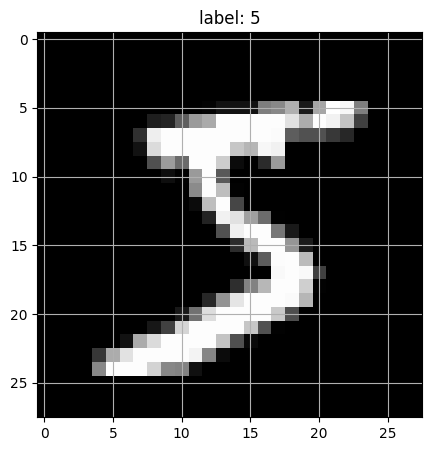

In [ ]:
# Load MNIST directly from Keras
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Dtype:", X_train.dtype)

# sample
plt.imshow(X_train[0], cmap='gray'); plt.title(f'label: {y_train[0]}'); plt.show()

## 2) Preprocess to NCHW, normalize, one-hot, split

- Normalize to `[0,1]` (`float32`).
- Reshape to **NCHW**: `(N, C=1, H=28, W=28)`.
- One-hot labels (10 classes).
- Split train into **48k train / 12k val**.


In [ ]:
# Normalize
X_train = (X_train.astype(np.float32) / 255.0).reshape(-1, 1, 28, 28)
X_test  = (X_test.astype(np.float32)  / 255.0).reshape(-1, 1, 28, 28)

# One-hot encode
try:
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
except TypeError:
    enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y_train_oh = enc.fit_transform(y_train.reshape(-1,1))
y_test_oh  = enc.transform(y_test.reshape(-1,1))

# Train/val split
X_train, X_val, y_train_oh, y_val_oh, y_train_i, y_val_i = train_test_split(
    X_train, y_train_oh, y_train, test_size=0.2, random_state=42, stratify=y_train
)
print('X_train:', X_train.shape, ' X_val:', X_val.shape, ' X_test:', X_test.shape)

X_train: (48000, 1, 28, 28)  X_val: (12000, 1, 28, 28)  X_test: (10000, 1, 28, 28)


## 3) Utilities: Softmax, Cross-Entropy, Accuracy

In [ ]:
def softmax_stable(logits):
    shift = logits - logits.max(axis=1, keepdims=True)
    ex = np.exp(shift)
    return ex / ex.sum(axis=1, keepdims=True)

def cross_entropy(y_true_onehot, y_pred_proba, eps=1e-7):
    yp = np.clip(y_pred_proba, eps, 1.0-eps)
    return -np.mean(np.sum(y_true_onehot * np.log(yp), axis=1))

def accuracy_from_proba(y_true_int, y_pred_proba):
    pred = np.argmax(y_pred_proba, axis=1)
    return float((pred == y_true_int).mean())

## 4) Initializers & Optimizers

In [ ]:
class SimpleInitializer:
    def __init__(self, sigma=0.01): self.sigma = float(sigma)
    def W(self, fan_in, fan_out): return self.sigma*np.random.standard_normal((fan_in, fan_out)).astype(np.float32)
    def B(self, fan_out): return np.zeros(fan_out, dtype=np.float32)

class XavierInitializer:
    def W(self, fan_in, fan_out):
        sigma = 1.0/np.sqrt(fan_in)
        return sigma*np.random.standard_normal((fan_in, fan_out)).astype(np.float32)
    def B(self, fan_out): return np.zeros(fan_out, dtype=np.float32)

class HeInitializer:
    def W(self, fan_in, fan_out):
        sigma = np.sqrt(2.0/fan_in)
        return sigma*np.random.standard_normal((fan_in, fan_out)).astype(np.float32)
    def B(self, fan_out): return np.zeros(fan_out, dtype=np.float32)

class SGD:
    def __init__(self, lr=0.1): self.lr = float(lr)
    def update(self, layer):
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.db
        return layer

class AdaGrad:
    def __init__(self, lr=0.1, eps=1e-8): self.lr=float(lr); self.eps=float(eps)
    def update(self, layer):
        if not hasattr(layer, 'hW'):
            layer.hW = np.zeros_like(layer.W, dtype=np.float32)
            layer.hB = np.zeros_like(layer.B, dtype=np.float32)
        layer.hW += layer.dW*layer.dW
        layer.hB += layer.db*layer.db
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.hW)+self.eps)
        layer.B -= self.lr * layer.db / (np.sqrt(layer.hB)+self.eps)
        return layer

## 5) FC, ReLU, Tanh, SoftmaxOutput, Flatten

In [ ]:
class FC:
    def __init__(self, n_in, n_out, initializer, optimizer):
        self.W = initializer.W(n_in, n_out)
        self.B = initializer.B(n_out)
        self.optimizer = optimizer
        self.X = None; self.dW=None; self.db=None
    def forward(self, X):
        self.X = X
        return X @ self.W + self.B
    def backward(self, dA):
        self.dW = self.X.T @ dA
        self.db = dA.sum(axis=0)
        dZ = dA @ self.W.T
        self.optimizer.update(self)
        return dZ

class ReLU:
    def __init__(self): self.mask=None
    def forward(self, X):
        self.mask = (X > 0).astype(np.float32)
        return np.maximum(0.0, X)
    def backward(self, dZ): return dZ * self.mask

class Tanh:
    def __init__(self): self.out=None
    def forward(self, X):
        self.out = np.tanh(X)
        return self.out
    def backward(self, dZ): return dZ * (1.0 - self.out**2)

class SoftmaxOutput:
    def forward(self, logits):
        return softmax_stable(logits)
    def backward(self, proba, y_true_onehot):
        N = y_true_onehot.shape[0]
        return (proba - y_true_onehot) / float(N)

class Flatten:
    def __init__(self): self.shape=None
    def forward(self, X):
        self.shape = X.shape
        return X.reshape(X.shape[0], -1)
    def backward(self, dZ):
        return dZ.reshape(self.shape)


## 6) Output-size utilities - Problems 2 & 3

In [ ]:
def conv1d_out_length(N_in, F, P=0, S=1):
    return int((N_in + 2*P - F)/S) + 1

def conv2d_out_hw(H_in, W_in, Fh, Fw, Ph=0, Pw=0, Sh=1, Sw=1):
    H_out = int((H_in + 2*Ph - Fh)/Sh) + 1
    W_out = int((W_in + 2*Pw - Fw)/Sw) + 1
    return H_out, W_out

print('2D out examples:')
print('28×28, F=3, P=0, S=1 ->', conv2d_out_hw(28,28,3,3,0,0,1,1))
print('28×28, F=5, P=0, S=1 ->', conv2d_out_hw(28,28,5,5,0,0,1,1))
print('28×28, F=5, P=2, S=1 ->', conv2d_out_hw(28,28,5,5,2,2,1,1), ' (same size)')

2D out examples:
28×28, F=3, P=0, S=1 -> (26, 26)
28×28, F=5, P=0, S=1 -> (24, 24)
28×28, F=5, P=2, S=1 -> (28, 28)  (same size)


## 7) im2col2d / col2im2d helpers (NCHW)

In [ ]:
def im2col2d(x, Fh, Fw, Sh=1, Sw=1, Ph=0, Pw=0):
    """
    x: (B, C, H, W) -> col: (B, H_out*W_out, C*Fh*Fw)
    """
    B, C, H, W = x.shape
    H_out, W_out = conv2d_out_hw(H, W, Fh, Fw, Ph, Pw, Sh, Sw)
    if Ph>0 or Pw>0:
        x_pad = np.pad(x, ((0,0),(0,0),(Ph,Ph),(Pw,Pw)), mode='constant')
    else:
        x_pad = x

    i0 = np.repeat(np.arange(Fh), Fw)
    i0 = np.tile(i0, C)
    j0 = np.tile(np.arange(Fw), Fh)
    j0 = np.tile(j0, C)
    k  = np.repeat(np.arange(C), Fh*Fw)

    i1 = Sh * np.arange(H_out)
    j1 = Sw * np.arange(W_out)
    i = i0.reshape(1,-1) + np.repeat(i1, W_out).reshape(-1,1)
    j = j0.reshape(1,-1) + np.tile(j1, H_out).reshape(-1,1)

    col = np.empty((B, H_out*W_out, C*Fh*Fw), dtype=x.dtype)
    for b in range(B):
        col[b] = x_pad[b, k, i, j]
    return col, (H_out, W_out), (H, W)

def col2im2d(col, x_shape, Fh, Fw, Sh=1, Sw=1, Ph=0, Pw=0):
    B, C, H, W = x_shape
    H_out, W_out = conv2d_out_hw(H, W, Fh, Fw, Ph, Pw, Sh, Sw)
    dX_pad = np.zeros((B, C, H + 2*Ph, W + 2*Pw), dtype=col.dtype)

    i0 = np.repeat(np.arange(Fh), Fw)
    i0 = np.tile(i0, C)
    j0 = np.tile(np.arange(Fw), Fh)
    j0 = np.tile(j0, C)
    k  = np.repeat(np.arange(C), Fh*Fw)

    i1 = Sh * np.arange(H_out)
    j1 = Sw * np.arange(W_out)
    i = i0.reshape(1,-1) + np.repeat(i1, W_out).reshape(-1,1)
    j = j0.reshape(1,-1) + np.tile(j1, H_out).reshape(-1,1)

    for b in range(B):
        np.add.at(dX_pad[b], (k, i, j), col[b])
    return dX_pad[:, :, Ph:H+Ph, Pw:W+Pw]

## 8) Conv2d Problem 1 - forward/backward, channels/stride/padding

In [ ]:
class Conv2d:
    def __init__(self, C_in, C_out, Fh, Fw, initializer, optimizer, Sh=1, Sw=1, Ph=0, Pw=0):
        self.C_in=int(C_in); self.C_out=int(C_out)
        self.Fh=int(Fh); self.Fw=int(Fw)
        self.Sh=int(Sh); self.Sw=int(Sw)
        self.Ph=int(Ph); self.Pw=int(Pw)
        self.optimizer = optimizer
        fan_in = self.C_in * self.Fh * self.Fw
        W_flat = initializer.W(fan_in, self.C_out)  # (fan_in, C_out)
        self.W = W_flat.T.reshape(self.C_out, self.C_in, self.Fh, self.Fw)  # (C_out,C_in,Fh,Fw)
        self.B = initializer.B(self.C_out)  # (C_out,)
        self.cache = {}

    def forward(self, x):
        # x: (B,C,H,W) -> out: (B,C_out,H_out,W_out)
        B, C, H, W = x.shape
        col, (H_out, W_out), (H_in, W_in) = im2col2d(x, self.Fh, self.Fw, self.Sh, self.Sw, self.Ph, self.Pw)
        W_flat = self.W.reshape(self.C_out, -1)  # (C_out, C*Fh*Fw)

        out_bnK = np.einsum('bnf,kf->bnk', col, W_flat) + self.B  # (B, H_out*W_out, C_out)
        out = out_bnK.transpose(0,2,1).reshape(B, self.C_out, H_out, W_out)

        self.cache = {'x_shape': x.shape, 'col': col, 'W_flat': W_flat, 'H_out': H_out, 'W_out': W_out}
        return out

    def backward(self, dA):
        # dA: (B,C_out,H_out,W_out) -> dX: (B,C,H,W)
        B, _, H_out, W_out = dA.shape
        col = self.cache['col']
        W_flat = self.cache['W_flat']

        dA_bnK = dA.transpose(0,2,3,1).reshape(B, H_out*W_out, self.C_out)  # (B, HW, C_out)

        dW_flat = np.einsum('bnk,bnf->kf', dA_bnK, col)  # (C_out, C*Fh*Fw)
        self.dW = dW_flat.reshape(self.W.shape)
        self.db = dA.sum(axis=(0,2,3))  # (C_out,)

        dcol = np.einsum('bnk,kf->bnf', dA_bnK, W_flat)  # (B, HW, C*Fh*Fw)
        dX = col2im2d(dcol, self.cache['x_shape'], self.Fh, self.Fw, self.Sh, self.Sw, self.Ph, self.Pw)

        self.optimizer.update(self)
        return dX

## 9) Problem 2 Small-array Conv2d test (forward/backward)

In [ ]:
# Input (B=1,C=1,H=4,W=4)
x = np.array([[[[ 1,  2,  3,  4],
                [ 5,  6,  7,  8],
                [ 9, 10, 11, 12],
                [13, 14, 15, 16]]]]).astype(np.float32)

# Two 3×3 filters (C_out=2, C_in=1)
w = np.array([[[[ 0.,  0.,  0.],
                [ 0.,  1.,  0.],
                [ 0., -1.,  0.]]],

              [[[ 0.,  0.,  0.],
                [ 0., -1.,  1.],
                [ 0.,  0.,  0.]]]], dtype=np.float32)

b = np.zeros(2, dtype=np.float32)

conv = Conv2d(C_in=1, C_out=2, Fh=3, Fw=3, initializer=SimpleInitializer(0.0), optimizer=SGD(lr=0.0), Sh=1, Sw=1, Ph=0, Pw=0)
conv.W = w.copy(); conv.B = b.copy()

out = conv.forward(x)
print('Forward output:\n', out.astype(int))

# Expect:
# [[[-4, -4],  [[ 1, 1],
#   [-4, -4]],  [ 1, 1]]]

# Now a made-up upstream gradient (2×2 per channel, 2 channels)
delta = np.array([[[[-4, -4],
                    [10, 11]],

                   [[ 1, -7],
                    [ 1,-11]]]], dtype=np.float32)

dX = conv.backward(delta)
print('db:', conv.db)                 # gradient wrt bias (sum of delta over spatial positions)
print('dW shape:', conv.dW.shape)
print('dX shape:', dX.shape)

Forward output:
 [[[[-4 -4]
   [-4 -4]]

  [[ 1  1]
   [ 1  1]]]]
db: [ 13. -16.]
dW shape: (2, 1, 3, 3)
dX shape: (1, 1, 4, 4)


## 10) Pooling layers, Problems 4 & 5: MaxPool2D and AveragePool2D

In [ ]:
class MaxPool2D:
    def __init__(self, Ph=2, Pw=2, Sh=2, Sw=2):
        self.Ph=int(Ph); self.Pw=int(Pw); self.Sh=int(Sh); self.Sw=int(Sw)
        self.cache = {}
    def forward(self, x):
        B, C, H, W = x.shape
        H_out = int((H - self.Ph)/self.Sh) + 1
        W_out = int((W - self.Pw)/self.Sw) + 1
        out = np.empty((B, C, H_out, W_out), dtype=x.dtype)
        self.argmax = np.zeros((B, C, H_out, W_out, 2), dtype=np.int32)
        for b in range(B):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        hs = i*self.Sh; ws = j*self.Sw
                        window = x[b,c, hs:hs+self.Ph, ws:ws+self.Pw]
                        idx = np.unravel_index(np.argmax(window), window.shape)
                        out[b,c,i,j] = window[idx]
                        self.argmax[b,c,i,j] = (hs+idx[0], ws+idx[1])
        self.cache['x_shape'] = x.shape
        return out
    def backward(self, dA):
        B, C, H, W = self.cache['x_shape']
        H_out, W_out = dA.shape[2], dA.shape[3]
        dX = np.zeros((B, C, H, W), dtype=dA.dtype)
        for b in range(B):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        (pi, pj) = self.argmax[b,c,i,j]
                        dX[b,c,pi,pj] += dA[b,c,i,j]
        return dX

class AveragePool2D:
    def __init__(self, Ph=2, Pw=2, Sh=2, Sw=2):
        self.Ph=int(Ph); self.Pw=int(Pw); self.Sh=int(Sh); self.Sw=int(Sw)
        self.cache = {}
    def forward(self, x):
        B, C, H, W = x.shape
        H_out = int((H - self.Ph)/self.Sh) + 1
        W_out = int((W - self.Pw)/self.Sw) + 1
        out = np.empty((B, C, H_out, W_out), dtype=x.dtype)
        self.cache['x_shape'] = x.shape
        for b in range(B):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        hs = i*self.Sh; ws = j*self.Sw
                        window = x[b,c, hs:hs+self.Ph, ws:ws+self.Pw]
                        out[b,c,i,j] = window.mean()
        return out
    def backward(self, dA):
        B, C, H, W = self.cache['x_shape']
        H_out, W_out = dA.shape[2], dA.shape[3]
        dX = np.zeros((B, C, H, W), dtype=dA.dtype)
        scale = 1.0 / (self.Ph * self.Pw)
        for b in range(B):
            for c in range(C):
                for i in range(H_out):
                    for j in range(W_out):
                        hs = i*self.Sh; ws = j*self.Sw
                        dX[b,c, hs:hs+self.Ph, ws:ws+self.Pw] += dA[b,c,i,j] * scale
        return dX

## 11) Mini-batch iterator

In [ ]:
class GetMiniBatch:
    def __init__(self, X, y, batch_size=128, seed=42):
        self.batch_size = int(batch_size)
        rng = np.random.default_rng(seed)
        order = rng.permutation(np.arange(X.shape[0]))
        self._X = X[order]
        self._y = y[order]
        self._stop = int(np.ceil(X.shape[0]/self.batch_size))
        self._i = 0
    def __len__(self): return self._stop
    def __iter__(self): self._i=0; return self
    def __next__(self):
        if self._i >= self._stop: raise StopIteration()
        p0 = self._i*self.batch_size; p1 = p0 + self.batch_size; self._i += 1
        return self._X[p0:p1], self._y[p0:p1]

## 12) Scratch2dCNNClassifier (Conv → ReLU → MaxPool → Flatten → FC → ReLU → FC → Softmax)

In [ ]:
class Scratch2dCNNClassifier:
    def __init__(self,
                 conv_out=8, conv_ks=(3,3), conv_stride=(1,1), conv_pad=(0,0),
                 hidden_dim=128,
                 initializer='he', sigma=0.01,
                 optimizer='adagrad', lr=0.2,
                 batch_size=128, epochs=5,
                 verbose=True, seed=42):
        self.C_out = int(conv_out)
        self.Kh, self.Kw = conv_ks
        self.Sh, self.Sw = conv_stride
        self.Ph, self.Pw = conv_pad
        self.hidden_dim = int(hidden_dim)
        self.initializer_name = initializer
        self.sigma = float(sigma)
        self.optimizer_name = optimizer
        self.lr = float(lr)
        self.batch_size = int(batch_size)
        self.epochs = int(epochs)
        self.verbose = verbose
        self.seed = int(seed)
        self.train_loss_=[]; self.val_loss_=[]
        self.train_acc_=[]; self.val_acc_=[]

    def _make_initializer(self):
        if self.initializer_name=='simple': return SimpleInitializer(self.sigma)
        if self.initializer_name=='xavier': return XavierInitializer()
        if self.initializer_name=='he':     return HeInitializer()
        raise ValueError('initializer must be simple/xavier/he')

    def _make_optimizer(self):
        if self.optimizer_name=='sgd': return SGD(self.lr)
        if self.optimizer_name=='adagrad': return AdaGrad(self.lr)
        raise ValueError('optimizer must be sgd/adagrad')

    def _build(self, input_shape=(1,28,28)):
        init = self._make_initializer(); opt = self._make_optimizer()
        C_in,H,W = input_shape
        self.conv = Conv2d(C_in=C_in, C_out=self.C_out, Fh=self.Kh, Fw=self.Kw,
                           initializer=init, optimizer=opt,
                           Sh=self.Sh, Sw=self.Sw, Ph=self.Ph, Pw=self.Pw)
        self.relu1 = ReLU()
        self.pool = MaxPool2D(Ph=2, Pw=2, Sh=2, Sw=2)
        # output shape after conv
        Hc, Wc = conv2d_out_hw(H, W, self.Kh, self.Kw, self.Ph, self.Pw, self.Sh, self.Sw)
        Hp, Wp = int((Hc - 2)/2)+1, int((Wc - 2)/2)+1
        fc_in = self.C_out * Hp * Wp
        self.flatten = Flatten()
        self.fc1 = FC(fc_in, self.hidden_dim, init, opt)
        self.act1 = ReLU()
        self.fc_out = FC(self.hidden_dim, 10, init, opt)
        self.softmax = SoftmaxOutput()

    def predict_proba(self, X):
        if not hasattr(self, 'conv'): self._build(input_shape=(X.shape[1], X.shape[2], X.shape[3]))
        z = self.relu1.forward(self.conv.forward(X))
        z = self.pool.forward(z)
        zf = self.flatten.forward(z)
        h = self.act1.forward(self.fc1.forward(zf))
        logits = self.fc_out.forward(h)
        return self.softmax.forward(logits)

    def fit(self, X, y_onehot, X_val=None, y_val=None, y_int=None, y_val_int=None):
        if not hasattr(self, 'conv'): self._build(input_shape=(X.shape[1], X.shape[2], X.shape[3]))
        for epoch in range(self.epochs):
            batcher = GetMiniBatch(X, y_onehot, batch_size=self.batch_size, seed=self.seed+epoch)
            for Xb, Yb in batcher:
                z1 = self.relu1.forward(self.conv.forward(Xb))
                z2 = self.pool.forward(z1)
                zf = self.flatten.forward(z2)
                h1 = self.act1.forward(self.fc1.forward(zf))
                logits = self.fc_out.forward(h1)
                proba = self.softmax.forward(logits)

                d_logits = self.softmax.backward(proba, Yb)
                d_h1 = self.fc_out.backward(d_logits)
                d_zf = self.act1.backward(d_h1)
                d_pool_in = self.fc1.backward(d_zf)
                d_z2 = self.flatten.backward(d_pool_in)
                d_z1 = self.pool.backward(d_z2)
                _ = self.conv.backward(d_z1)

            # End-epoch metrics
            tr_proba = self.predict_proba(X)
            tr_loss = cross_entropy(y_onehot, tr_proba)
            self.train_loss_.append(tr_loss)
            if y_int is not None: self.train_acc_.append(accuracy_from_proba(y_int, tr_proba))

            if X_val is not None and y_val is not None:
                vl_proba = self.predict_proba(X_val)
                vl_loss = cross_entropy(y_val, vl_proba)
                self.val_loss_.append(vl_loss)
                if y_val_int is not None: self.val_acc_.append(accuracy_from_proba(y_val_int, vl_proba))

            if self.verbose:
                msg = f"Epoch {epoch+1}/{self.epochs} - loss: {tr_loss:.4f}"
                if self.val_loss_: msg += f" - val_loss: {self.val_loss_[-1]:.4f}"
                if self.train_acc_: msg += f" - acc: {self.train_acc_[-1]:.4f}"
                if self.val_acc_: msg += f" - val_acc: {self.val_acc_[-1]:.4f}"
                print(msg)
        return self

    def predict(self, X): return np.argmax(self.predict_proba(X), axis=1)

## 13) Train the scratch 2D CNN on MNIST, Problem 7

Epoch 1/2 - loss: 0.0901 - val_loss: 0.1348 - acc: 0.9711 - val_acc: 0.9573
Epoch 2/2 - loss: 0.0394 - val_loss: 0.0986 - acc: 0.9881 - val_acc: 0.9692


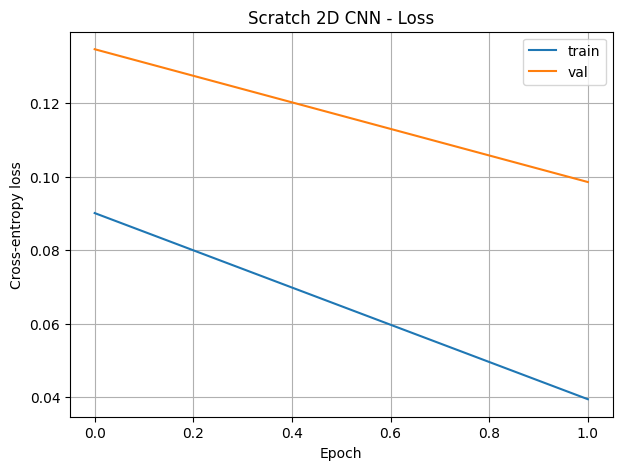

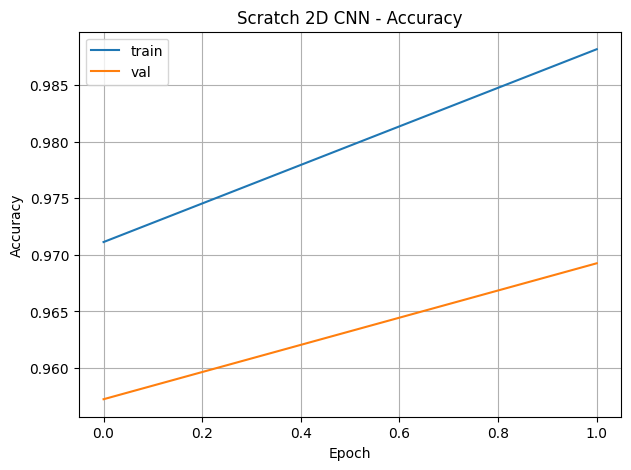

Validation accuracy: 0.9692
Test accuracy: 0.9740


In [ ]:
model = Scratch2dCNNClassifier(conv_out=8, conv_ks=(3,3), conv_stride=(1,1), conv_pad=(0,0),
                                hidden_dim=128, initializer='he', optimizer='adagrad',
                                lr=0.2, batch_size=128, epochs=2, verbose=True)
_ = model.fit(X_train, y_train_oh, X_val=X_val, y_val=y_val_oh, y_int=y_train_i, y_val_int=y_val_i)

plt.figure(); plt.plot(model.train_loss_, label='train');
if len(model.val_loss_)==len(model.train_loss_): plt.plot(model.val_loss_, label='val')
plt.xlabel('Epoch'); plt.ylabel('Cross-entropy loss'); plt.title('Scratch 2D CNN - Loss'); plt.legend(); plt.show()

if model.train_acc_ and model.val_acc_:
    plt.figure(); plt.plot(model.train_acc_, label='train'); plt.plot(model.val_acc_, label='val')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Scratch 2D CNN - Accuracy'); plt.legend(); plt.show()

val_acc = accuracy_from_proba(y_val_i, model.predict_proba(X_val))
test_acc = accuracy_from_proba(y_test, model.predict_proba(X_test))
print('Validation accuracy:', f'{val_acc:.4f}')
print('Test accuracy:', f'{test_acc:.4f}')

## 14) LeNet-style network (Problem 8)

Epoch 1/2 - loss: 0.0665 - val_loss: 0.0815 - acc: 0.9800 - val_acc: 0.9730
Epoch 2/2 - loss: 0.0425 - val_loss: 0.0651 - acc: 0.9871 - val_acc: 0.9803


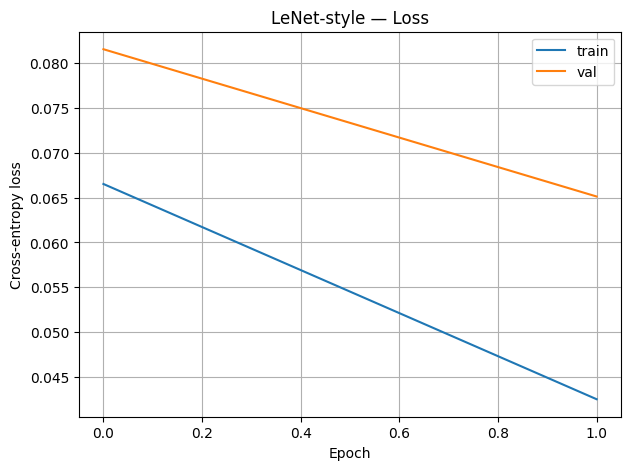

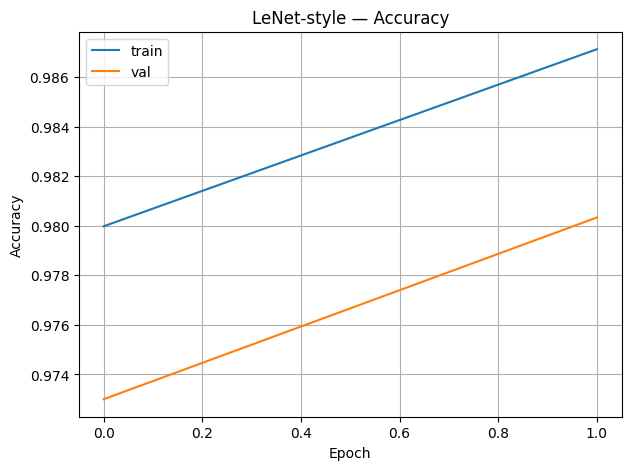

LeNet-style Validation accuracy: 0.9803
LeNet-style Test accuracy: 0.9784


In [ ]:
class LeNetScratch:
    def __init__(self, initializer='he', optimizer='adagrad', lr=0.05, epochs=2, batch_size=64, verbose=True):
        self.initializer_name = initializer
        self.optimizer_name   = optimizer
        self.lr       = float(lr)
        self.epochs   = int(epochs)
        self.batch_size = int(batch_size)
        self.verbose  = verbose
        self.train_loss_ = []
        self.val_loss_   = []
        self.train_acc_  = []
        self.val_acc_    = []

    def _make_initializer(self):
        if self.initializer_name == 'simple': return SimpleInitializer(0.01)
        if self.initializer_name == 'xavier': return XavierInitializer()
        if self.initializer_name == 'he':     return HeInitializer()
        raise ValueError(f"Unknown initializer '{self.initializer_name}'")

    def _make_optimizer(self):
        if self.optimizer_name == 'sgd':     return SGD(self.lr)
        if self.optimizer_name == 'adagrad': return AdaGrad(self.lr)
        raise ValueError(f"Unknown optimizer '{self.optimizer_name}'")

    def _build(self):
        init = self._make_initializer()

        # fresh optimizer instance per layer
        def make_opt(): return self._make_optimizer()

        # LeNet feature extractor
        self.conv1 = Conv2d(1,  6, 5, 5, initializer=init, optimizer=make_opt(), Sh=1, Sw=1, Ph=0, Pw=0)
        self.relu1 = ReLU()
        self.pool1 = MaxPool2D(2, 2, 2, 2)

        self.conv2 = Conv2d(6, 16, 5, 5, initializer=init, optimizer=make_opt(), Sh=1, Sw=1, Ph=0, Pw=0)
        self.relu2 = ReLU()
        self.pool2 = MaxPool2D(2, 2, 2, 2)

        # 28 -  conv5 valid - 24 - pool2 - 12 - conv5 valid - 8 - pool2 - 4
        self.flatten = Flatten()

        # Classifier head
        self.fc1    = FC(16*4*4, 120, init, make_opt())
        self.act1   = ReLU()
        self.fc2    = FC(120, 84, init, make_opt())
        self.act2   = ReLU()
        self.fc_out = FC(84, 10, init, make_opt())
        self.softmax = SoftmaxOutput()

    def predict_proba(self, X):
        if not hasattr(self, 'conv1'):
            self._build()
        z = self.conv1.forward(X)
        z = self.relu1.forward(z)
        z = self.pool1.forward(z)

        z = self.conv2.forward(z)
        z = self.relu2.forward(z)
        z = self.pool2.forward(z)

        zf = self.flatten.forward(z)
        h1 = self.fc1.forward(zf); h1 = self.act1.forward(h1)
        h2 = self.fc2.forward(h1); h2 = self.act2.forward(h2)
        logits = self.fc_out.forward(h2)
        proba  = self.softmax.forward(logits)
        return proba

    def fit(self, X, y_onehot, X_val=None, y_val=None, y_int=None, y_val_int=None):
        if not hasattr(self, 'conv1'):
            self._build()

        for epoch in range(self.epochs):
            batcher = GetMiniBatch(X, y_onehot, batch_size=self.batch_size, seed=42+epoch)
            for Xb, Yb in batcher:
                # forward
                z1 = self.conv1.forward(Xb)
                z1 = self.relu1.forward(z1)
                z1 = self.pool1.forward(z1)

                z2 = self.conv2.forward(z1)
                z2 = self.relu2.forward(z2)
                z2 = self.pool2.forward(z2)

                zf = self.flatten.forward(z2)
                h1 = self.fc1.forward(zf); h1 = self.act1.forward(h1)
                h2 = self.fc2.forward(h1); h2 = self.act2.forward(h2)
                logits = self.fc_out.forward(h2)
                proba  = self.softmax.forward(logits)

                # backward (correct gate ordering)
                d_logits   = self.softmax.backward(proba, Yb)
                d_h2_in    = self.fc_out.backward(d_logits)
                d_h2_out   = self.act2.backward(d_h2_in)
                d_h1_in    = self.fc2.backward(d_h2_out)
                d_h1_out   = self.act1.backward(d_h1_in)
                d_zf       = self.fc1.backward(d_h1_out)
                d_z2       = self.flatten.backward(d_zf)

                d_after_pool2 = self.pool2.backward(d_z2)
                d_after_relu2 = self.relu2.backward(d_after_pool2)
                d_after_conv2 = self.conv2.backward(d_after_relu2)

                d_after_pool1 = self.pool1.backward(d_after_conv2)
                d_after_relu1 = self.relu1.backward(d_after_pool1)
                _             = self.conv1.backward(d_after_relu1)

            # epoch metrics
            tr_proba = self.predict_proba(X)
            tr_loss  = cross_entropy(y_onehot, tr_proba)
            self.train_loss_.append(tr_loss)
            if y_int is not None:
                self.train_acc_.append(accuracy_from_proba(y_int, tr_proba))

            if X_val is not None and y_val is not None:
                vl_proba = self.predict_proba(X_val)
                vl_loss  = cross_entropy(y_val, vl_proba)
                self.val_loss_.append(vl_loss)
                if y_val_int is not None:
                    self.val_acc_.append(accuracy_from_proba(y_val_int, vl_proba))

            if self.verbose:
                msg = f"Epoch {epoch+1}/{self.epochs} - loss: {self.train_loss_[-1]:.4f}"
                if self.val_loss_: msg += f" - val_loss: {self.val_loss_[-1]:.4f}"
                if self.train_acc_: msg += f" - acc: {self.train_acc_[-1]:.4f}"
                if self.val_acc_: msg += f" - val_acc: {self.val_acc_[-1]:.4f}"
                print(msg)
        return self

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


# Train for 2 epochs - to save time
lenet = LeNetScratch(epochs=2, batch_size=64, lr=0.05, optimizer='adagrad', initializer='he', verbose=True)
_ = lenet.fit(X_train, y_train_oh, X_val=X_val, y_val=y_val_oh, y_int=y_train_i, y_val_int=y_val_i)

# Curves
plt.figure()
plt.plot(lenet.train_loss_, label='train')
if len(lenet.val_loss_) == len(lenet.train_loss_): plt.plot(lenet.val_loss_, label='val')
plt.xlabel('Epoch'); plt.ylabel('Cross-entropy loss'); plt.title('LeNet-style — Loss'); plt.legend(); plt.show()

if lenet.train_acc_ and lenet.val_acc_:
    plt.figure()
    plt.plot(lenet.train_acc_, label='train'); plt.plot(lenet.val_acc_, label='val')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('LeNet-style — Accuracy'); plt.legend(); plt.show()

# Eval
val_acc_lenet = accuracy_from_proba(y_val_i, lenet.predict_proba(X_val))
test_acc_lenet = accuracy_from_proba(y_test, lenet.predict_proba(X_test))
print('LeNet-style Validation accuracy:', f'{val_acc_lenet:.4f}')
print('LeNet-style Test accuracy:', f'{test_acc_lenet:.4f}')

Colab Keeps Crashing for using all the available RAM, but this cell above should do the job!

In [ ]:
""" # An example of what not to do.
We are reusing the same optimizer instance for every layer, the newer updates do not matter. Hence the poor performance?
class LeNetScratch:
    def __init__(self, initializer='he', optimizer='adagrad', lr=0.2, epochs=3, batch_size=128, verbose=True):
        self.initializer_name=initializer; self.optimizer_name=optimizer
        self.lr=float(lr); self.epochs=int(epochs); self.batch_size=int(batch_size); self.verbose=verbose
        self.train_loss_=[]; self.val_loss_=[]; self.train_acc_=[]; self.val_acc_=[]
    def _make_initializer(self):
        if self.initializer_name=='simple': return SimpleInitializer(0.01)
        if self.initializer_name=='xavier': return XavierInitializer()
        if self.initializer_name=='he':     return HeInitializer()
        raise ValueError()
    def _make_optimizer(self):
        if self.optimizer_name=='sgd': return SGD(self.lr)
        if self.optimizer_name=='adagrad': return AdaGrad(self.lr)
        raise ValueError()
    def _build(self):
        init=self._make_initializer(); opt=self._make_optimizer()
        self.conv1 = Conv2d(1, 6, 5, 5, initializer=init, optimizer=opt, Sh=1, Sw=1, Ph=0, Pw=0)
        self.relu1 = ReLU()
        self.pool1 = MaxPool2D(2,2,2,2)
        self.conv2 = Conv2d(6,16,5,5, initializer=init, optimizer=opt, Sh=1, Sw=1, Ph=0, Pw=0)
        self.relu2 = ReLU()
        self.pool2 = MaxPool2D(2,2,2,2)
        # Output sizes: 28->(5x5 valid)->24 -> pool->12; then (5x5 valid)->8 -> pool->4
        self.flatten = Flatten()
        self.fc1 = FC(16*4*4, 120, init, opt)
        self.act1 = ReLU()
        self.fc2 = FC(120, 84, init, opt)
        self.act2 = ReLU()
        self.fc_out = FC(84, 10, init, opt)
        self.softmax = SoftmaxOutput()
    def predict_proba(self, X):
        if not hasattr(self,'conv1'): self._build()
        z = self.pool1.forward(self.relu1.forward(self.conv1.forward(X)))
        z = self.pool2.forward(self.relu2.forward(self.conv2.forward(z)))
        zf = self.flatten.forward(z)
        h1 = self.act1.forward(self.fc1.forward(zf))
        h2 = self.act2.forward(self.fc2.forward(h1))
        logits = self.fc_out.forward(h2)
        return self.softmax.forward(logits)
    def fit(self, X, y_onehot, X_val=None, y_val=None, y_int=None, y_val_int=None):
        if not hasattr(self,'conv1'): self._build()
        for epoch in range(self.epochs):
            batcher = GetMiniBatch(X, y_onehot, batch_size=self.batch_size, seed=42+epoch)
            for Xb, Yb in batcher:
                z1 = self.pool1.forward(self.relu1.forward(self.conv1.forward(Xb)))
                z2 = self.pool2.forward(self.relu2.forward(self.conv2.forward(z1)))
                zf = self.flatten.forward(z2)
                h1 = self.act1.forward(self.fc1.forward(zf))
                h2 = self.act2.forward(self.fc2.forward(h1))
                logits = self.fc_out.forward(h2)
                proba = self.softmax.forward(logits)

                d_logits = self.softmax.backward(proba, Yb)
                d_h2 = self.fc_out.backward(d_logits)
                d_h1 = self.act2.backward(d_h2)
                d_zf = self.fc2.backward(d_h1)
                d_z2 = self.act1.backward(d_zf)
                d_pool_in = self.fc1.backward(d_z2)
                d_pool2 = self.flatten.backward(d_pool_in)
                d_relu2 = self.pool2.backward(d_pool2)
                d_conv2 = self.conv2.backward(d_relu2)
                d_relu1 = self.pool1.backward(d_conv2)
                _ = self.conv1.backward(d_relu1)

            tr_proba = self.predict_proba(X)
            tr_loss = cross_entropy(y_onehot, tr_proba)
            self.train_loss_.append(tr_loss)
            if y_int is not None: self.train_acc_.append(accuracy_from_proba(y_int, tr_proba))

            if X_val is not None and y_val is not None:
                vl_proba = self.predict_proba(X_val)
                vl_loss = cross_entropy(y_val, vl_proba)
                self.val_loss_.append(vl_loss)
                if y_val_int is not None: self.val_acc_.append(accuracy_from_proba(y_val_int, vl_proba))

            if self.verbose:
                msg = f"Epoch {epoch+1}/{self.epochs} - loss: {tr_loss:.4f}"
                if self.val_loss_: msg += f" - val_loss: {self.val_loss_[-1]:.4f}"
                if self.train_acc_: msg += f" - acc: {self.train_acc_[-1]:.4f}"
                if self.val_acc_: msg += f" - val_acc: {self.val_acc_[-1]:.4f}"
                print(msg)
        return self
    def predict(self, X): return np.argmax(self.predict_proba(X), axis=1)

lenet = LeNetScratch(epochs=3, batch_size=128, lr=0.15, verbose=True)
_ = lenet.fit(X_train, y_train_oh, X_val=X_val, y_val=y_val_oh, y_int=y_train_i, y_val_int=y_val_i)

plt.figure(); plt.plot(lenet.train_loss_, label='train');
if len(lenet.val_loss_)==len(lenet.train_loss_): plt.plot(lenet.val_loss_, label='val')
plt.xlabel('Epoch'); plt.ylabel('Cross-entropy loss'); plt.title('LeNet-style - Loss'); plt.legend(); plt.show()

if lenet.train_acc_ and lenet.val_acc_:
    plt.figure(); plt.plot(lenet.train_acc_, label='train'); plt.plot(lenet.val_acc_, label='val')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('LeNet-style - Accuracy'); plt.legend(); plt.show()

val_acc_lenet = accuracy_from_proba(y_val_i, lenet.predict_proba(X_val))
test_acc_lenet = accuracy_from_proba(y_test, lenet.predict_proba(X_test))
print('LeNet-style Validation accuracy:', f'{val_acc_lenet:.4f}')
print('LeNet-style Test accuracy:', f'{test_acc_lenet:.4f}')
"""

' # An example of what not to do. \nWe are reusing the same optimizer instance for every layer, the newer updates do not matter. Hence the poor performance?\nclass LeNetScratch:\n    def __init__(self, initializer=\'he\', optimizer=\'adagrad\', lr=0.2, epochs=3, batch_size=128, verbose=True):\n        self.initializer_name=initializer; self.optimizer_name=optimizer\n        self.lr=float(lr); self.epochs=int(epochs); self.batch_size=int(batch_size); self.verbose=verbose\n        self.train_loss_=[]; self.val_loss_=[]; self.train_acc_=[]; self.val_acc_=[]\n    def _make_initializer(self):\n        if self.initializer_name==\'simple\': return SimpleInitializer(0.01)\n        if self.initializer_name==\'xavier\': return XavierInitializer()\n        if self.initializer_name==\'he\':     return HeInitializer()\n        raise ValueError()\n    def _make_optimizer(self):\n        if self.optimizer_name==\'sgd\': return SGD(self.lr)\n        if self.optimizer_name==\'adagrad\': return AdaGrad(

Garbage in garbage out (GIGO)
Do not follow this cell

## 16) Problem 10, Output sizes & parameter counts for three conv layers

In [ ]:
def conv2d_params(C_in, C_out, Fh, Fw, bias=True):
    return C_out * (C_in*Fh*Fw) + (C_out if bias else 0)

def describe_layer(H_in, W_in, C_in, Fh, Fw, C_out, Sh=1, Sw=1, Ph=0, Pw=0):
    H_out, W_out = conv2d_out_hw(H_in, W_in, Fh, Fw, Ph, Pw, Sh, Sw)
    params = conv2d_params(C_in, C_out, Fh, Fw, bias=True)
    return H_out, W_out, params

# 1) 144x144x3 -> 3x3, 6 filters, stride1, no pad
h1,w1,p1 = describe_layer(144,144,3,3,3,6,1,1,0,0)
print('1) Out:', (6,h1,w1), ' Params:', p1)

# 2) 60x60x24 -> 3x3, 48 filters, stride1, no pad
h2,w2,p2 = describe_layer(60,60,24,3,3,48,1,1,0,0)
print('2) Out:', (48,h2,w2), ' Params:', p2)

# 3) 20x20x10 -> 3x3, 20 filters, stride2, no pad
h3,w3,p3 = describe_layer(20,20,10,3,3,20,2,2,0,0)
print('3) Out:', (20,h3,w3), ' Params:', p3)

1) Out: (6, 142, 142)  Params: 168
2) Out: (48, 58, 58)  Params: 10416
3) Out: (20, 9, 9)  Params: 1820
